In [1]:
import os
from configparser import ConfigParser

config = ConfigParser()
config.read('../conf.ini')
openai_token=config['secret']['openai_token']
os.environ['OPENAI_API_KEY'] = openai_token

# Retrieval
- LLM 어플리케이션은 사용자별 데이터가 필요함
    - Retrieval Augmented Generation (RAG)를 통해서 이를 실현할 수 있음
    - 외부 데이터를 검색한 후에 generation step에서 LLM에 전달
- LangChain에서는 RAG를 위한 빌딩 블록을 제공

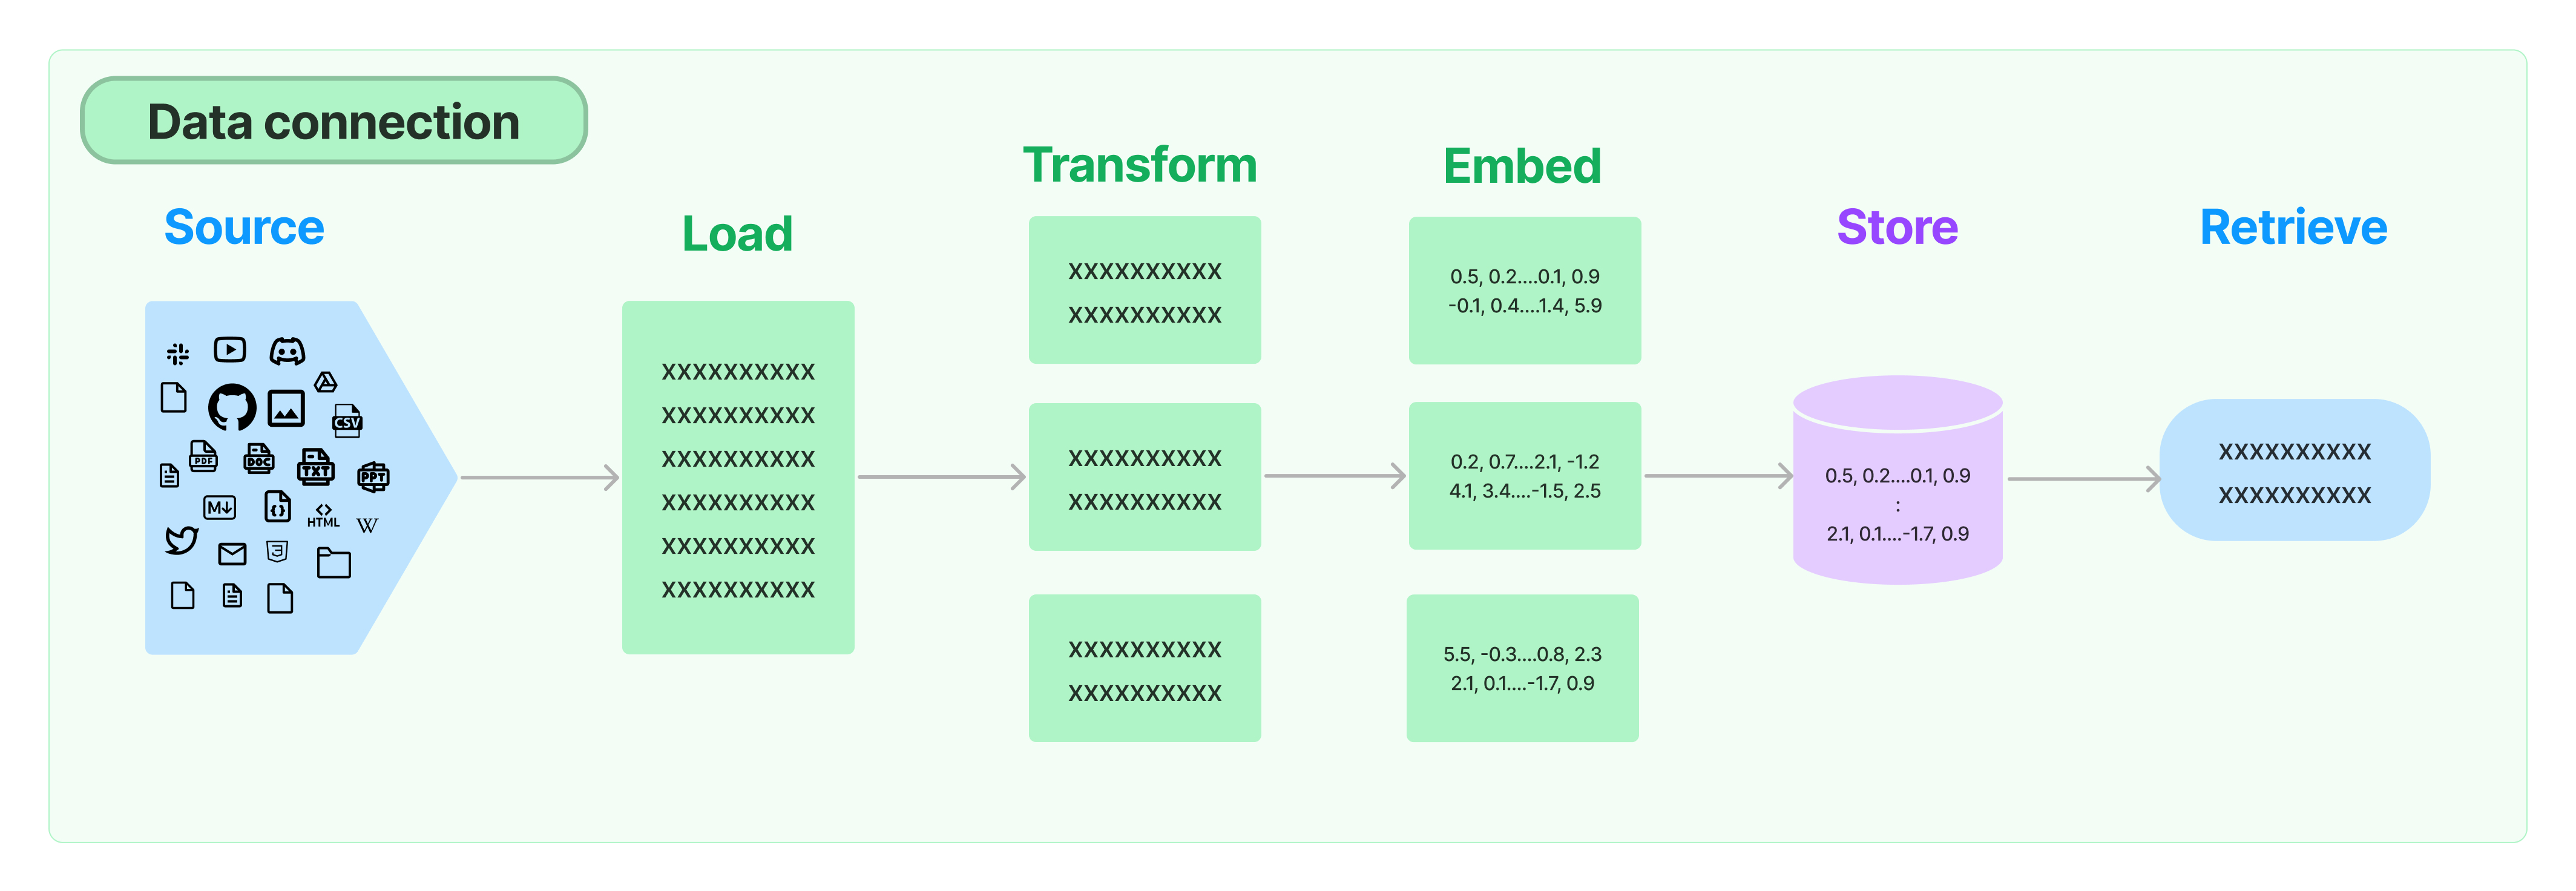

- Document Loader
    - 많은 소스들에서 Document를 로드함
    - Langchain은 100개의 Document Loader를 제공
- Document transformers
    - 문서의 관련 부분만 가져옴
    - 큰 덩어리를 작은 덩어리로 분할 (chunking)
- Text Embedding Models
    - 문서에 대한 임베딩 필요
    - 텍스트의 의미론적 의미를 포착하여 다른 텍스트와의 유사함을 빠르고 효율적으로 찾을 수 있게 도움
- Vector Stores
    - 임베딩의 효율적인 저장 및 검색을 위함
    - 표준 인터페이스를 제공, 벡터 저장소 간에 쉽게 전환 가능
- Retrivers
    - Parnet Document Retriever: 상위 문서당 여러 임베딩 생성
    - Self Query Retriever: 쿼리에 있는 다른 메타데이터 필터에서 쿼리의 의미 부분을 구문 분석
    - Ensemble Retriever: 여러 다른 소스/알고리즘을 사용하여 문서를 검색

## Document transformers

### Text splitters

#### Split Code

In [6]:
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    Language,
)

print("지원 Language 종류")
print([e.value for e in Language])

지원 Language 종류
['cpp', 'go', 'java', 'js', 'php', 'proto', 'python', 'rst', 'ruby', 'rust', 'scala', 'swift', 'markdown', 'latex', 'html', 'sol']


In [2]:
PYTHON_CODE = """
def hello_world():
    print("Hello, World!")

# Call the function
hello_world()
"""
python_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.PYTHON, chunk_size=50, chunk_overlap=0   # language에 어떤 언어를 Split할 것인지 선택
)
python_docs = python_splitter.create_documents([PYTHON_CODE])
python_docs

[Document(page_content='def hello_world():\n    print("Hello, World!")', metadata={}),
 Document(page_content='# Call the function\nhello_world()', metadata={})]

#### MarkdownHeaderTextSplitter
- md 파일에는 #, ## 으로 metadata (Header 등) 을 관리

In [8]:
from langchain.text_splitter import MarkdownHeaderTextSplitter
markdown_document = "# Intro \n\n    ## History \n\n Markdown[9] is a lightweight markup language for creating formatted text using a plain-text editor. John Gruber created Markdown in 2004 as a markup language that is appealing to human readers in its source code form.[9] \n\n Markdown is widely used in blogging, instant messaging, online forums, collaborative software, documentation pages, and readme files. \n\n ## Rise and divergence \n\n As Markdown popularity grew rapidly, many Markdown implementations appeared, driven mostly by the need for \n\n additional features such as tables, footnotes, definition lists,[note 1] and Markdown inside HTML blocks. \n\n #### Standardization \n\n From 2012, a group of people, including Jeff Atwood and John MacFarlane, launched what Atwood characterised as a standardisation effort. \n\n ## Implementations \n\n Implementations of Markdown are available for over a dozen programming languages."

headers_to_split_on = [  # 메타 데이터로 구분할 것 선정
    ("#", "Header 1"),
    ("##", "Header 2"),
]

markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
md_header_splits = markdown_splitter.split_text(markdown_document)

# Chunking
from langchain.text_splitter import RecursiveCharacterTextSplitter

chunk_size = 250 
chunk_overlap = 30  # chunk_size 보다 큰 메모리를 할당 받고 싶을 때
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size, chunk_overlap=chunk_overlap
)

splits = text_splitter.split_documents(md_header_splits)
splits

[Document(page_content='Markdown[9] is a lightweight markup language for creating formatted text using a plain-text editor. John Gruber created Markdown in 2004 as a markup language that is appealing to human readers in its source code form.[9]', metadata={'Header 1': 'Intro', 'Header 2': 'History'}),
 Document(page_content='Markdown is widely used in blogging, instant messaging, online forums, collaborative software, documentation pages, and readme files.', metadata={'Header 1': 'Intro', 'Header 2': 'History'}),
 Document(page_content='As Markdown popularity grew rapidly, many Markdown implementations appeared, driven mostly by the need for  \nadditional features such as tables, footnotes, definition lists,[note 1] and Markdown inside HTML blocks.  \n#### Standardization', metadata={'Header 1': 'Intro', 'Header 2': 'Rise and divergence'}),
 Document(page_content='#### Standardization  \nFrom 2012, a group of people, including Jeff Atwood and John MacFarlane, launched what Atwood chara

#### Recursively split by character
- Chunk에 충분히 작아질 때까지 순서대로 분할하려고 시도
- Split 기준의 기본 목록은 ["\n\n", "\n", " ", ""]
- Character의 개수를 기준으로 chunk size 결정

In [4]:
with open('./files/state_of_the_union.txt', encoding="UTF8") as f:
    state_of_the_union = f.read()
    
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 100,
    chunk_overlap  = 20,
    length_function = len,
    is_separator_regex = False,
)

texts = text_splitter.create_documents([state_of_the_union])
print(texts[0])

page_content='Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and' metadata={}


#### Split by tokens
- 언어 모델에는 토큰 제한이 있음. 이것을 초과하면 안 됨 > 토큰 수를 세는 것이 좋음
- tokenizer는 언어 모델에서 사용된 것과 동일한 것으로 사용해야함

In [ ]:
with open('./files/state_of_the_union.txt', encoding="UTF8") as f:
    state_of_the_union = f.read()
    
from langchain.text_splitter import CharacterTextSplitter, SpacyTextSplitter, NLTKTextSplitter, GPT2TokenizerFast

# Tiktoken
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=0
)
texts = text_splitter.split_text(state_of_the_union)

# Spacy
text_splitter = SpacyTextSplitter(chunk_size=1000)
texts = text_splitter.split_text(state_of_the_union)

# NLTK
text_splitter = NLTKTextSplitter(chunk_size=1000)
texts = text_splitter.split_text(state_of_the_union)

# Hugging Face Tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
text_splitter = CharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer, chunk_size=100, chunk_overlap=0
)
texts = text_splitter.split_text(state_of_the_union)

### Lost in the middle: The problem with long contexts
- 모델에 Context를 input할 때, 문서를 10개 이상 포함하면 성능이 크게 저하
- 모델은 중간의 Document를 무시하는 경향이 있음
- 이를 위해서 관련있는 Document들은 양 끝에 위치시키도록 재정리할 수 있음

In [2]:
import os
import chromadb
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.document_transformers import (
    LongContextReorder,
)
from langchain.chains import StuffDocumentsChain, LLMChain
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI

# Get embeddings.
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

texts = [
    "Basquetball is a great sport.",
    "Fly me to the moon is one of my favourite songs.",
    "The Celtics are my favourite team.",
    "This is a document about the Boston Celtics",
    "I simply love going to the movies",
    "The Boston Celtics won the game by 20 points",
    "This is just a random text.",
    "Elden Ring is one of the best games in the last 15 years.",
    "L. Kornet is one of the best Celtics players.",
    "Larry Bird was an iconic NBA player.",
]

# Create a retriever
retriever = Chroma.from_texts(texts, embedding=embeddings).as_retriever(
    search_kwargs={"k": 10}
)
query = "What can you tell me about the Celtics?"

# Get relevant documents ordered by relevance score
docs = retriever.get_relevant_documents(query)
docs

d:\Gang\study\Practice-LLM\llm_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[Document(page_content='This is a document about the Boston Celtics', metadata={}),
 Document(page_content='The Celtics are my favourite team.', metadata={}),
 Document(page_content='L. Kornet is one of the best Celtics players.', metadata={}),
 Document(page_content='The Boston Celtics won the game by 20 points', metadata={}),
 Document(page_content='Larry Bird was an iconic NBA player.', metadata={}),
 Document(page_content='Elden Ring is one of the best games in the last 15 years.', metadata={}),
 Document(page_content='Basquetball is a great sport.', metadata={}),
 Document(page_content='I simply love going to the movies', metadata={}),
 Document(page_content='Fly me to the moon is one of my favourite songs.', metadata={}),
 Document(page_content='This is just a random text.', metadata={})]

In [5]:
# Reorder the documents:
# Less relevant document will be at the middle of the list and more
# relevant elements at beginning / end.
reordering = LongContextReorder()
reordered_docs = reordering.transform_documents(docs)

# Confirm that the 4 relevant documents are at beginning and end.
reordered_docs

[Document(page_content='The Celtics are my favourite team.', metadata={}),
 Document(page_content='The Boston Celtics won the game by 20 points', metadata={}),
 Document(page_content='Elden Ring is one of the best games in the last 15 years.', metadata={}),
 Document(page_content='I simply love going to the movies', metadata={}),
 Document(page_content='This is just a random text.', metadata={}),
 Document(page_content='Fly me to the moon is one of my favourite songs.', metadata={}),
 Document(page_content='Basquetball is a great sport.', metadata={}),
 Document(page_content='Larry Bird was an iconic NBA player.', metadata={}),
 Document(page_content='L. Kornet is one of the best Celtics players.', metadata={}),
 Document(page_content='This is a document about the Boston Celtics', metadata={})]

In [6]:
# We prepare and run a custom Stuff chain with reordered docs as context.

# Override prompts
document_prompt = PromptTemplate(
    input_variables=["page_content"], template="{page_content}"
)
document_variable_name = "context"

llm = OpenAI()
stuff_prompt_override = """Given this text extracts:
-----
{context}
-----
Please answer the following question:
{query}"""

prompt = PromptTemplate(
    template=stuff_prompt_override, input_variables=["context", "query"]
)

# Instantiate the chain
llm_chain = LLMChain(llm=llm, prompt=prompt)
chain = StuffDocumentsChain(
    llm_chain=llm_chain,
    document_prompt=document_prompt,
    document_variable_name=document_variable_name,
)
chain.run(input_documents=reordered_docs, query=query)

'\n\nThe Celtics are a professional basketball team based in Boston, Massachusetts. They have won multiple championships and are one of the most successful teams in the NBA. Larry Bird was an iconic player for the Celtics and L. Kornet is one of their current best players. They have recently won a game by 20 points.'

## Text Embedding Models
- Embedding은 텍스트 조각을 Vector로 변환
- Document Input(검색 대상) or Query Input(검색 쿼리 자체)을 지원

In [7]:
# 임베딩 정보를 캐쉬에 보관하여, 같은 text에 대해서 두번 검색하지 않아도 되도록 함
from langchain.storage import InMemoryStore, LocalFileStore, RedisStore
from langchain.embeddings import OpenAIEmbeddings, CacheBackedEmbeddings

Vector Store 사용

In [10]:
from langchain.document_loaders import TextLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS

underlying_embeddings = OpenAIEmbeddings()
fs = LocalFileStore("./cache/")

cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    underlying_embeddings = underlying_embeddings,
    document_embedding_cache=fs,
    namespace=underlying_embeddings.model,
)

list(fs.yield_keys())

[]

In [12]:
raw_documents = TextLoader("./files/state_of_the_union.txt", encoding="UTF-8").load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
documents = text_splitter.split_documents(raw_documents)

In [13]:
db = FAISS.from_documents(documents, cached_embedder)

In [15]:
print(len(list(fs.yield_keys())))
print(list(fs.yield_keys())[:5])

42
['text-embedding-ada-00201dbc21f-5e4c-5fb5-8d13-517dbe7a32d4', 'text-embedding-ada-002059eb9ff-c4c8-5ceb-8bf9-0d3d02a92b44', 'text-embedding-ada-0020fc1ede2-407a-5e14-8f8f-5642214263f5', 'text-embedding-ada-0021297d37a-2bc1-5e19-bf13-6c950f075062', 'text-embedding-ada-00217a6727d-8916-54eb-b196-ec9c9d6ca472']


In-Memory 사용

In [16]:
store = InMemoryStore()
underlying_embeddings = OpenAIEmbeddings()
embedder = CacheBackedEmbeddings.from_bytes_store(
    underlying_embeddings, store, namespace=underlying_embeddings.model
)

embeddings = embedder.embed_documents(["hello", "goodbye"])

## Retrievers

#### MultiQueryRetriever
- 입력 Query > LLM > 유사한 여러 Query를 생성
- 입력 Query에 대해서 다양한 관점에서 여러 쿼리를 생성 > 풍부한 결과 세트를 얻을 수 있음

In [3]:
from langchain.vectorstores import Chroma
from langchain.document_loaders import WebBaseLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Load blog post
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
splits = text_splitter.split_documents(data)

# VectorDB
embedding = OpenAIEmbeddings()
vectordb = Chroma.from_documents(documents=splits, embedding=embedding)

In [7]:
from langchain.chat_models import ChatOpenAI
from langchain.retrievers.multi_query import MultiQueryRetriever

question = "What are the approaches to Task Decomposition?"
llm = ChatOpenAI(temperature=0)
retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=vectordb.as_retriever(), llm=llm
)

In [5]:
import logging

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

unique_docs = retriever_from_llm.get_relevant_documents(query=question)
len(unique_docs)

INFO:langchain.retrievers.multi_query:Generated queries: ['1. How can Task Decomposition be approached?', '2. What are the different methods for Task Decomposition?', '3. What are the various approaches to decomposing tasks?']


5

#### Contextual compression
- 정보 중 Query와 가장 관련있는 정보인데, Text가 관련이 없어서 묻혀질 수 있음
- 검색된 문서를 그대로 반환하는 대신 Context를 통해 압축해서 관련 정보만 반환
- Query > Base retriever > Documents > Compressor > 압축된 Document

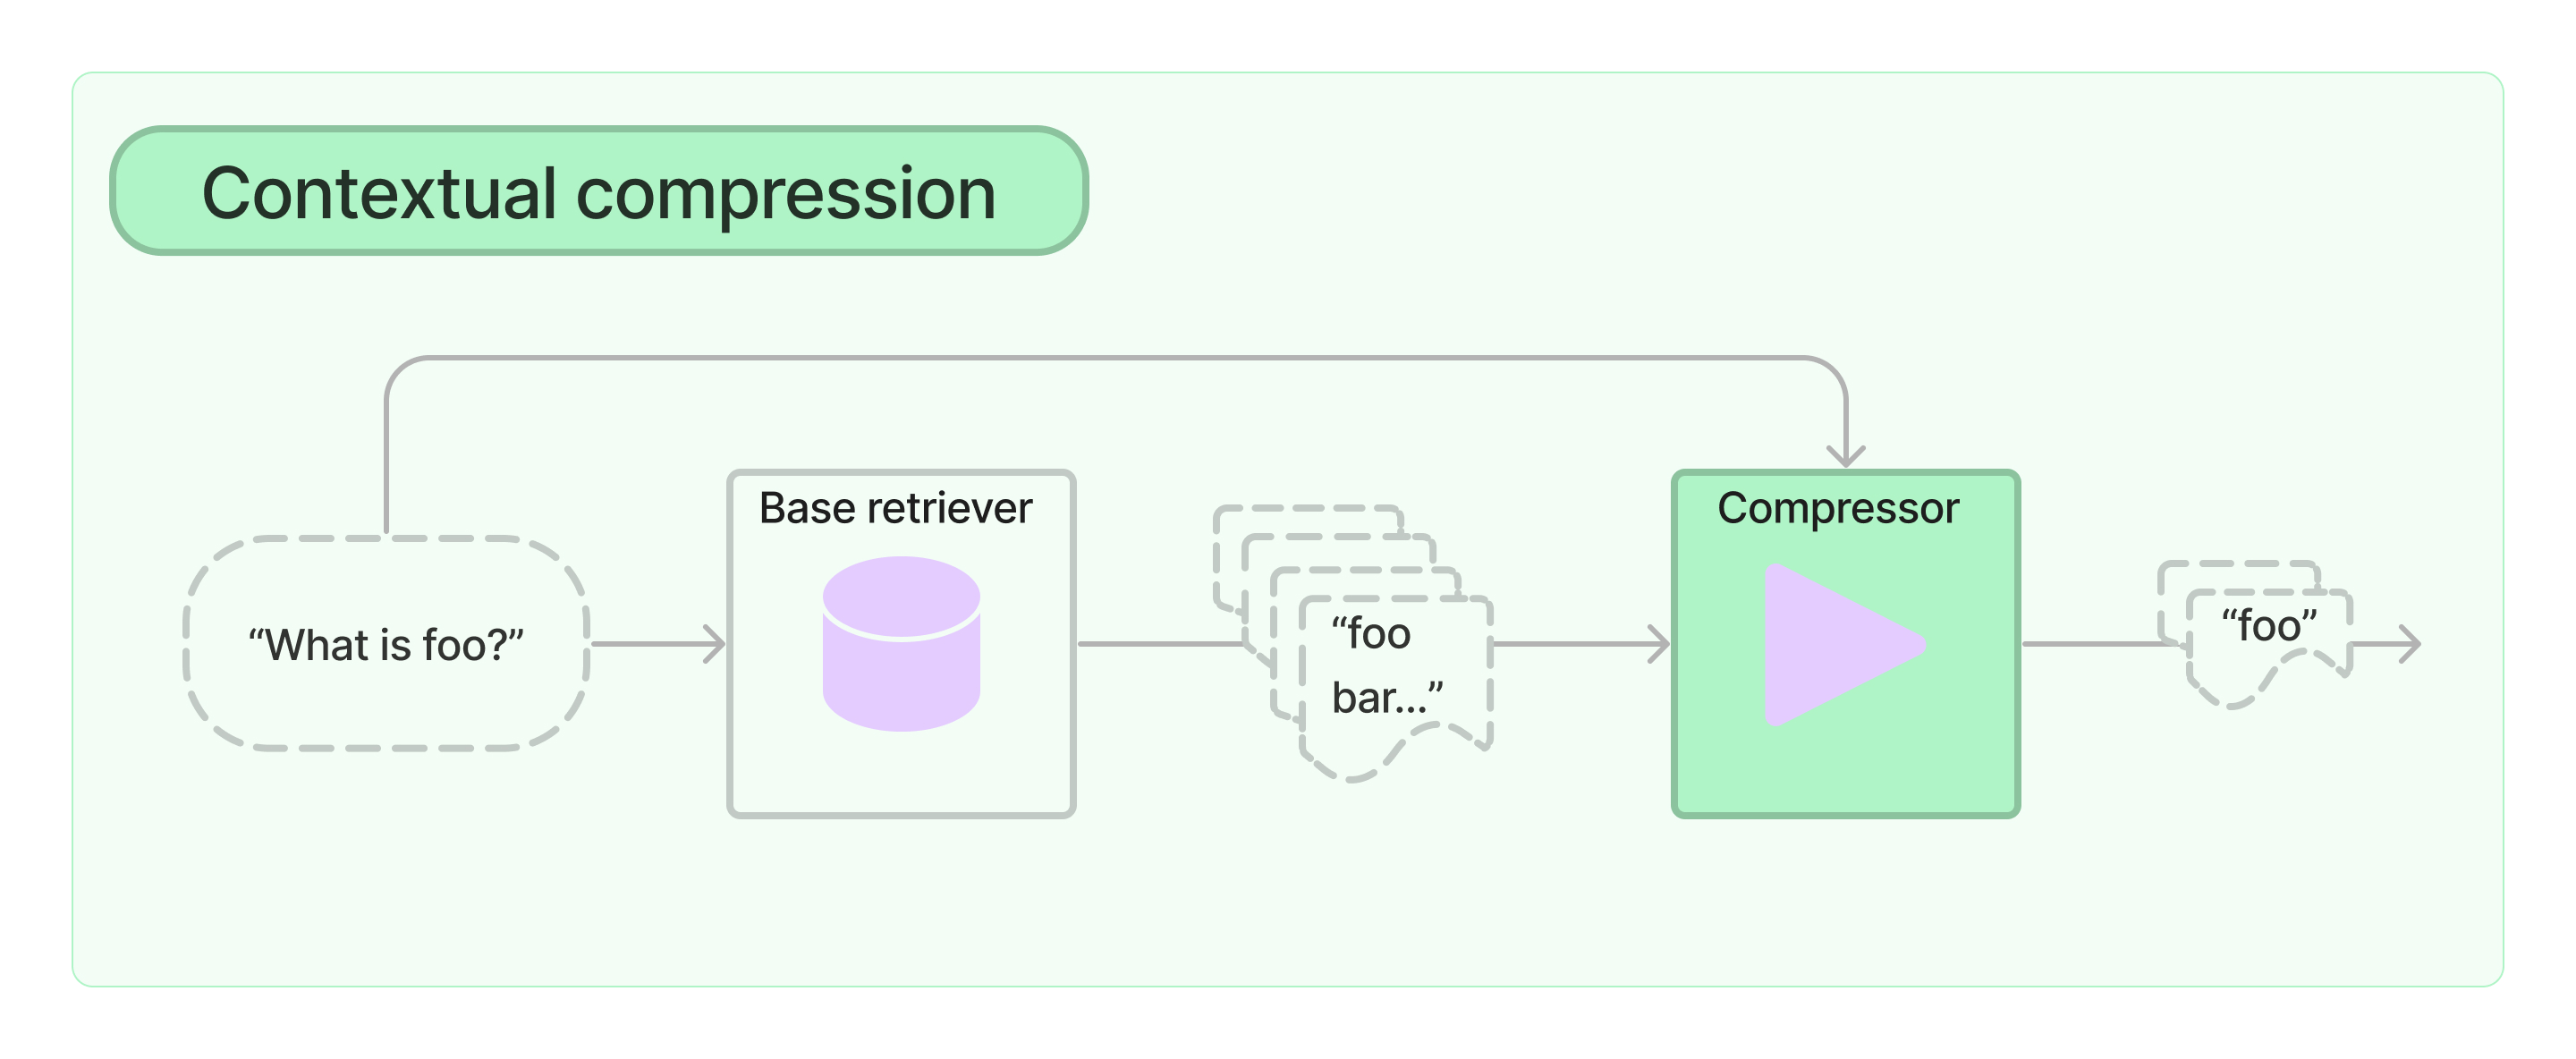

In [10]:
def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n" + d.page_content for i, d in enumerate(docs)]))

In [32]:
from langchain.document_loaders import WebBaseLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
# Load blog post
loader = WebBaseLoader("https://namu.wiki/w/%EC%82%BC%EC%84%B1%20%EB%9D%BC%EC%9D%B4%EC%98%A8%EC%A6%88")
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap  = 20,
    length_function = len,
    is_separator_regex = False,
)

texts = text_splitter.split_documents(documents)
retriever = FAISS.from_documents(texts, OpenAIEmbeddings()).as_retriever()

In [35]:
docs = retriever.get_relevant_documents("이승엽이 누구입니까?")
pretty_print_docs(docs)

Document 1:

98이승엽1루수.6211999이승엽1루수.7332002이승엽1루수.6892011최형우외야수.617삼성
----------------------------------------------------------------------------------------------------
Document 2:

999이승엽1루수542001이승엽1루수392002이승엽1루수472003이승엽1루수562007심정수외야수312011최형우외야수30삼성
----------------------------------------------------------------------------------------------------
Document 3:

이승엽이 삼성 복귀를 얘기했을 때 "이승엽 와도 자리 없다"며 이를 거부함으로써[94] 삼성의 레전드들을 부정한 선 감독에 대한 인식은 매우 악화되었고, 그해 한국시리즈에서
----------------------------------------------------------------------------------------------------
Document 4:

팔로우하고 있고 아들이 이승엽 올드 유니폼을 가지고 있다고 한다. 공교롭게도 아들의 이름이 이승엽이다.앤덥★: 수험생 시절 삼성 라이온즈를 응원하며 버텼다고 한다. 쇼미더머니에서


In [37]:
from langchain.llms import OpenAI
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor, LLMChainFilter

llm = OpenAI(temperature=0)
compressor = LLMChainExtractor.from_llm(llm)
# _filter = LLMChainFilter.from_llm(llm)  # 
compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever)

In [38]:
compressed_docs = compression_retriever.get_relevant_documents("이승엽이 누구입니까?")
pretty_print_docs(compressed_docs)

d:\Gang\study\Practice-LLM\llm_env\lib\site-packages\langchain\chains\llm.py:278: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Document 1:

"이승엽이 삼성 복귀를 얘기했을 때 "이승엽 와도 자리 없다"며 이를 거부함으로써[94] 삼성의 레전드들을 부정한 선 감독에 대한 인식은 매우 악화되었고, 그해 한국시리즈에서
----------------------------------------------------------------------------------------------------
Document 2:

이승엽 올드 유니폼을 가지고 있다고 한다. 공교롭게도 아들의 이름이 이승엽이다. 수험생 시절 삼성 라이온즈를 응원하며 버텼다고 한다.


#### Ensemble Retriever
- Reciprocal Rank Fusion algorithm을 사용해서 결과를 앙상블함
- Spare Retriever(BM25 등)과 Dense Retriever(Embedding similarity 등)이 상호보완적이라서 둘의 결과를 활용하는 것이 일반적

In [40]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.vectorstores import FAISS

doc_list = [
    "I like apples",
    "I like oranges",
    "Apples and oranges are fruits",
]

bm25_retriever = BM25Retriever.from_texts(doc_list)
bm25_retriever.k = 2

embedding = OpenAIEmbeddings()
faiss_vectorstore = FAISS.from_texts(doc_list, embedding)
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 2})

# initialize the ensemble retriever
ensemble_retriever = EnsembleRetriever(retrievers=[bm25_retriever, faiss_retriever], weights=[0.5, 0.5])

In [41]:
docs = ensemble_retriever.get_relevant_documents("apples")
print(docs)

[Document(page_content='I like apples', metadata={}), Document(page_content='Apples and oranges are fruits', metadata={})]


#### Parent Document Retriever
- 문서를 분할할 때 두가지가 상충됨
    1. 임베딩이 document의 의미를 정확하게 반영할 수 있도록 작은 문서가 필요 (너무 크면 임베딩이 제대로 의미를 담을 수 없을 수도 있음)
    1. Chunk Context가 유지될만큼의 충분한 길이의 문서가 필요
- 작은 Chunk와 Parent Document (작은 Chunk가 시작되는 문서)로 구성
- 검색 > 작은 Chunk > 상위 ID를 찾아 더 큰 Document를 반환

In [44]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.storage import InMemoryStore
from langchain.document_loaders import TextLoader

loaders = [
    TextLoader('./files/paul_graham_essay.txt', encoding="UTF-8"),
    TextLoader('./files/state_of_the_union.txt', encoding="UTF-8"),
]
docs = []
for l in loaders:
    docs.extend(l.load())

In [48]:
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=2000)
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400)
vectorstore = Chroma(collection_name="split_parents", embedding_function=OpenAIEmbeddings())
store = InMemoryStore()

retriever = ParentDocumentRetriever(
    vectorstore=vectorstore, 
    docstore=store, 
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
)
retriever.add_documents(docs, ids=None)

len(list(store.yield_keys()))

66

In [49]:
# Small Chunk
sub_docs = vectorstore.similarity_search("justice breyer")
print(sub_docs[0].page_content)

Tonight, I’d like to honor someone who has dedicated his life to serve this country: Justice Stephen Breyer—an Army veteran, Constitutional scholar, and retiring Justice of the United States Supreme Court. Justice Breyer, thank you for your service. 

One of the most serious constitutional responsibilities a President has is nominating someone to serve on the United States Supreme Court.


In [50]:
# Parent Document
retrieved_docs = retriever.get_relevant_documents("justice breyer")
print(retrieved_docs[0].page_content)

In state after state, new laws have been passed, not only to suppress the vote, but to subvert entire elections. 

We cannot let this happen. 

Tonight. I call on the Senate to: Pass the Freedom to Vote Act. Pass the John Lewis Voting Rights Act. And while you’re at it, pass the Disclose Act so Americans can know who is funding our elections. 

Tonight, I’d like to honor someone who has dedicated his life to serve this country: Justice Stephen Breyer—an Army veteran, Constitutional scholar, and retiring Justice of the United States Supreme Court. Justice Breyer, thank you for your service. 

One of the most serious constitutional responsibilities a President has is nominating someone to serve on the United States Supreme Court. 

And I did that 4 days ago, when I nominated Circuit Court of Appeals Judge Ketanji Brown Jackson. One of our nation’s top legal minds, who will continue Justice Breyer’s legacy of excellence. 

A former top litigator in private practice. A former federal publi